In [1]:
from collections import defaultdict
import itertools as it
import numpy as np

from adict import adict

In [2]:
def x(i, j, c):
    """Variable label"""
    return f"x{i}_{j}_{c}"

def xs(i, j):
    """Variable label"""
    return f"x{i}_{j}"

def ind(var: str):
    """Return position indices from variable label"""
    i, j, c = var[1:].split('_')
    return (int(i), int(j), int(c))

def grid_parameters(grid, star):
    return len(grid), np.sum(star[0])

def inds(var: str):
    """Return position indices from variable label"""
    i, j = var[1:].split('_')
    return (int(i), int(j))

def row_regions(N):
    return [[(i, j) for j in range(N)] for i in range(N)]

def column_regions(N):
    return [[(i, j) for i in range(N)] for j in range(N)]

def region_lists(grid: np.array):
    """Lists of region indices from grid"""
    regions = defaultdict(list)
    for (i, j), r in np.ndenumerate(grid):
        regions[r].append((i, j))
    return list(regions.values())

In [3]:
"""Penalties and constraints"""
# There is a strange problem with iterables here, all generators were converted to lists.

def penalties(N):
    """Closest neighbours should be different.
    This is a penalty of type x * y, which is 1 iff x=y=1."""

    Q = adict(int)
    positions = list(it.product(range(N-1), repeat=2))  # Exclude last row/column

    for (i, j) in positions:
        neighbours = [(i+1, j), (i, j+1), (i+1, j+1)]
        for (i_, j_) in neighbours:
            Q[xs(i,j), xs(i_,j_)] += 1
        Q[xs(i+1, j), xs(i, j+1)] += 1 # Anti-diagonal

    last_row = last_col = N-1
    for l in range(N-1):
        Q[xs(last_row, l), xs(last_row, l+1)] += 1
        Q[xs(l, last_col), xs(l+1, last_col)] += 1
        
    return Q

def region_constraint(region: list, nstars: int):
    """All points in :region: sum to :nstars:."""
    Q = adict(int)
    for (i, j) in region:
        Q[xs(i,j), xs(i,j)] -= 2*nstars
        for (l, p) in region:
            Q[xs(i,j), xs(l,p)] += 1
    return Q

def constraint_sum_of_stars(N, nstars, star_positions):
    """Sum of stars of certain color should be :nstars:"""
    Q = adict(int)
    colors = list(range(N))
    prod_pos = list(it.product(star_positions, repeat=2))
    for c in colors:
        for (i, j) in star_positions:
            Q[x(i, j, c), x(i, j, c)] += -2 * nstars
        for (i, j), (i_, j_) in prod_pos:
            Q[x(i, j, c), x(i_, j_, c)] += 1
    return Q

def constraint_sum_of_sites(N, color_size):
    """Sum of sites of certain color should be :N:"""
    Q = adict(int)
    positions = list(it.product(range(N), repeat=2))
    colors = list(range(N))
    prod_pos = list(it.product(positions, repeat=2))
    for c in colors:
        for (i, j) in positions:
            Q[x(i, j, c), x(i, j, c)] += -2 * color_size[c]
        for (i, j), (i_, j_) in prod_pos:
            Q[x(i, j, c), x(i_, j_, c)] += 1
    #display(Q)
    return Q

def constraint_unique_color(N):
    """One site should have only one color."""
    Q = adict(int)
    positions = list(it.product(range(N), repeat=2))
    colors = list(range(N))
    prod_colors = list(it.product(colors, repeat=2))
    for (i, j) in positions:
        for c in colors:
            Q[x(i, j, c), x(i, j, c)] += -2
        for c, c_ in prod_colors:
            Q[x(i, j, c), x(i, j, c_)] += 1
    return Q

def constraint_contiguous(N):
    """A color region should be contiguous.
    We favor having same-color neighbours."""
    Q = adict(int)
    positions = list(it.product(range(N-1), repeat=2))  # Exclude last row/column
    colors = list(range(N))
    for c in colors:
        for (i, j) in positions:
            Q[x(i,j,c), x(i+1,j,c)] += -1
            Q[x(i,j,c), x(i,j+1,c)] += -1

        last_row = last_col = N-1
        for l in range(N-1):
            Q[x(last_row, l,c), x(last_row, l+1,c)] += -1
            Q[x(l, last_col,c), x(l+1, last_col,c)] += -1
        
    return Q

In [4]:
import matplotlib.pyplot as plt

def draw_puzzle(grid, star):
    fig, ax = plt.subplots()
    mat = ax.imshow(grid, cmap='GnBu', interpolation='nearest')
    for x in range(star.shape[0]):
        for y in range(star.shape[1]):
            if star[x,y] == 1:
                ax.annotate("*", xy=(y, x), horizontalalignment='center', verticalalignment='center',size=30)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def star_solutions(sample):
    star_positions = [inds(var) for var, value in sample.items() if value == 1]
    solution = np.zeros((N, N), dtype=int)
    for (i, j) in star_positions:
        solution[i, j] = 1
    return star_positions, solution

def grid_solutions(sample):
    reg_colors = [ind(var) for var, value in sample.items() if value == 1]
    solution = np.zeros((N, N), dtype=int)
    for (i, j, c) in reg_colors:
        solution[i, j] = c
    return solution
    
def sample_to_plot(sample_star, sample_reg=None):
    if sample_reg is None:
        grid = np.zeros((N, N), dtype=int)
        _, solution = star_solutions(sample_star)
    else:
        grid = grid_solutions(sample_reg)
        solution = sample_star
    draw_puzzle(grid, solution)

In [25]:
"""Solution checks"""

def region_criterion(sample, region: list, nstars: int):
    '''Check if :sample: respects :region: criterion'''
    region_sum = sum(sample[xs(i, j)] for (i, j) in region)
    return region_sum == nstars
    
def proximity_criterion(sample):
    star_positions = [inds(var) for var, value in sample.items() if value == 1]
    bad_distances = {(0, 1), (1, 0), (1, 1)}
    for (i, j), (i_, j_) in it.combinations(star_positions, 2):
        dist = di, dj = abs(i - i_), abs(j - j_)
        if dist in bad_distances:
            return False
    return True

def confirm_solution_stars(sample, regions, nstars):
    '''Check if sample corresponds solves problem'''
    for region in regions:
        if not region_criterion(sample, region, nstars):
            return False
        
    if not proximity_criterion(sample):
        return False
    
    return True

def confirm_solution_regions(sample_star, grid, nstars):
    '''Check if :grid: serves :sample_star: solution.'''
    
    regions = region_lists(grid) # do not check list/column regions 
    for region in regions:
        if not region_criterion(sample_star, region, nstars):
            return False   
        if not connected(region):
            return False
        
        
    return True

In [26]:
def get_star_positions(sampleset, n):
    sorted_records = sorted(sampleset.record, key=lambda r: r.energy)
    variables = sampleset.variables
    record = sorted_records[n]
    sample = {x_ij: value for x_ij, value in zip(variables, record.sample)}
    energy = record.energy
    cond_1 = confirm_solution_stars(sample, regions, nstars)
    cond_2 = abs(energy-minimum_theo) < 1e-6
    print('Satisfies constraints:', cond_1)
    print('Has lowest energy:', cond_2)
    stars, solution = star_solutions(sample)
    return stars, solution, sample

In [27]:
def find_neighbours(cell, region):
    neighbours = []
    for other_cell in region:
        manhattan = abs(cell[0] - other_cell[0]) + abs(cell[1] - other_cell[1])
        if manhattan == 1:
            neighbours.append(list(other_cell))
    return neighbours
        
def connected_component(region):
    conn = [list(region[0])] # first cell of connected component
    cell_idx = 0
    while cell_idx < len(conn): 
        cell = conn[cell_idx] 
        neighbours = find_neighbours(cell, region) # find neighbours of cell in region
        for neighbour in neighbours:
            if not neighbour in conn:
                conn.append(neighbour) # add found neighbours to connected component
        cell_idx += 1
    return conn

def connected(region):
    conn = connected_component(region)  
    conn_set = {tuple(pos) for pos in conn}
    region_set = {tuple(pos) for pos in region}
    return conn_set == region_set

In [7]:
# Input data


"""
grid = np.array([[0,1,1,1,1],
                [0,1,1,1,2],
                [0,0,0,2,2],
                [3,0,3,2,2],
                [3,3,3,4,4]])

star = np.array([[0,1,0,0,0],
                [0,0,0,0,1],
                [0,0,1,0,0],
                [1,0,0,0,0],
                [0,0,0,1,0]])
"""

grid = np.array([
    [0, 0, 0, 0, 1, 1, 2, 2, 2, 2],
    [0, 4, 0, 0, 1, 1, 1, 2, 1, 1],
    [0, 4, 4, 1, 1, 1, 1, 1, 1, 1],
    [4, 4, 4, 4, 1, 5, 5, 5, 5, 1],
    [4, 4, 1, 1, 1, 1, 1, 1, 5, 1],
    [6, 6, 6, 6, 7, 7, 8, 8, 8, 8],
    [6, 9, 6, 6, 7, 7, 7, 8, 7, 7],
    [6, 9, 9, 7, 7, 7, 7, 7, 7, 7],
    [9, 9, 9, 9, 7, 10, 10, 10, 10, 7],
    [9, 9, 7, 7, 7, 7, 7, 7, 10, 7],
])

star = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
])

"""
a, b, c, d, e, f, g, h, i, j, k, l, m, n, o = range(15)
grid = np.array([
    [a, a, a, a, a, b, b, b, b, b, c, c, c, c, c],
    [a, d, d, d, d, b, b, b, b, b, e, e, e, c, c],
    [a, d, d, d, d, d, d, b, e, e, e, e, e, e, c],
    [a, d, d, d, f, d, d, b, e, e, g, e, e, e, c],
    [a, d, d, f, f, f, h, h, h, g, g, g, e, e, c],
    [a, a, a, f, f, f, h, h, h, g, g, g, c, c, c],
    [a, a, h, h, f, h, h, i, h, h, g, h, c, c, c],
    [a, a, a, h, h, h, i, i, i, h, h, h, j, j, j],
    [a, a, a, k, k, k, i, i, i, k, k, k, k, l, j],
    [a, a, a, m, k, k, k, i, k, k, k, m, l, l, j],
    [n, n, n, m, m, k, k, k, k, k, m, m, l, l, j],
    [n, n, n, o, m, m, m, m, m, m, m, l, l, l, j],
    [n, o, o, o, o, m, m, m, m, m, o, o, l, l, l],
    [n, o, o, o, o, o, m, m, m, o, o, o, l, l, l],
    [n, n, o, o, o, o, o, o, o, o, o, o, l, l, l],
])
"""

N, nstars = grid_parameters(grid, star) # Grid size and number of stars
N, nstars = 10, 2

## Generate Stars

In [8]:
# Build Star Finder QUBO

Q_star = penalties(N)

regions = [
    *row_regions(N),
    *column_regions(N),
]

γ = 1
for region in regions:
    Q_star = Q_star + γ * region_constraint(region, nstars)

### Annealing

In [9]:
# Create Sampler

"""
# Simulated sampling

import neal
sampler = neal.SimulatedAnnealingSampler()

# Try Sampling
sampleset = sampler.sample_qubo(Q, num_reads=20_000)
# print(sampleset)
"""

# # Go to DWave
# from dwave.system import LeapHybridSampler
# LEAPsampler = LeapHybridSampler()

# # Try Sampling
# LEAPsampleset = LEAPsampler.sample_qubo(Q)
# print(LEAPsampleset)

import neal
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(Q_star, num_reads=100)
#sampleset = LEAPsampleset
minimum_theo = -2*N* nstars**2 * γ
print('Theory:', minimum_theo)
print(sampleset)

Theory: -80
   x0_0 x0_1 x0_2 x0_3 x0_4 x0_5 x0_6 x0_7 x0_8 x0_9 ... x9_9 energy num_oc.
3     0    0    1    0    1    0    0    0    0    0 ...    1  -80.0       1
4     0    1    0    1    0    0    0    0    0    0 ...    0  -80.0       1
7     0    0    1    0    1    0    0    0    0    0 ...    0  -80.0       1
10    1    0    1    0    0    0    0    0    0    0 ...    0  -80.0       1
13    0    0    0    0    0    1    0    1    0    0 ...    0  -80.0       1
16    0    0    0    0    1    0    0    1    0    0 ...    0  -80.0       1
23    0    1    0    1    0    0    0    0    0    0 ...    0  -80.0       1
24    0    0    1    0    0    1    0    0    0    0 ...    0  -80.0       1
25    0    1    0    0    0    0    1    0    0    0 ...    0  -80.0       1
30    0    1    0    0    0    0    1    0    0    0 ...    0  -80.0       1
31    0    1    0    0    1    0    0    0    0    0 ...    0  -80.0       1
33    0    0    0    0    0    1    0    0    1    0 ...    0  -

Satisfies constraints: True
Has lowest energy: True


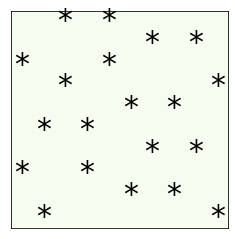

Satisfies constraints: True
Has lowest energy: True


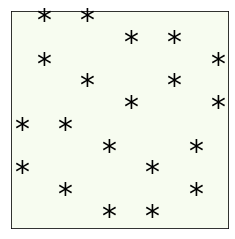

Satisfies constraints: True
Has lowest energy: True


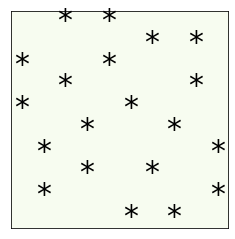

Satisfies constraints: True
Has lowest energy: True


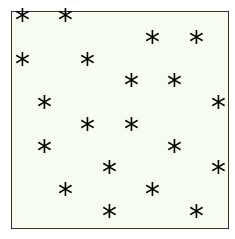

Satisfies constraints: True
Has lowest energy: True


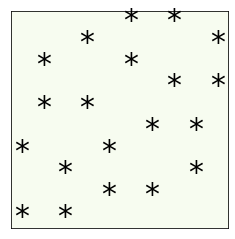

Satisfies constraints: True
Has lowest energy: True


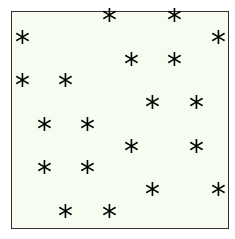

Satisfies constraints: True
Has lowest energy: True


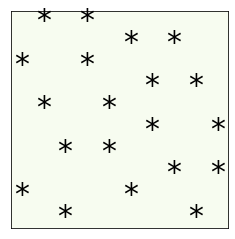

Satisfies constraints: True
Has lowest energy: True


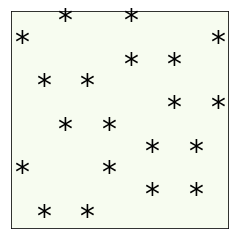

Satisfies constraints: True
Has lowest energy: True


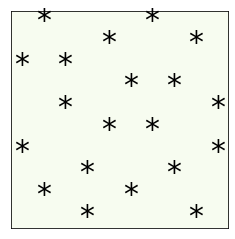

Satisfies constraints: True
Has lowest energy: True


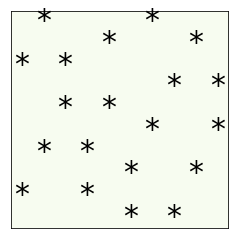

Satisfies constraints: True
Has lowest energy: True


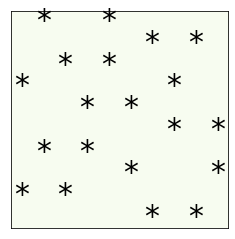

Satisfies constraints: True
Has lowest energy: True


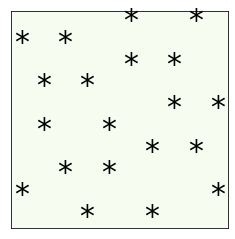

Satisfies constraints: True
Has lowest energy: True


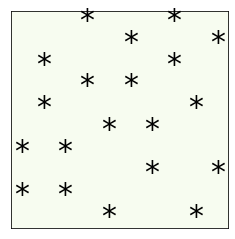

Satisfies constraints: True
Has lowest energy: True


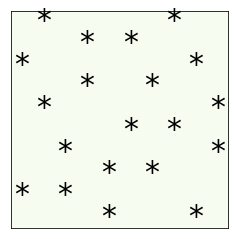

Satisfies constraints: True
Has lowest energy: True


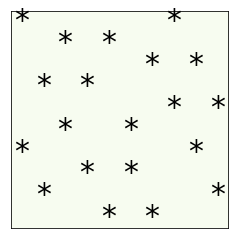

Satisfies constraints: True
Has lowest energy: True


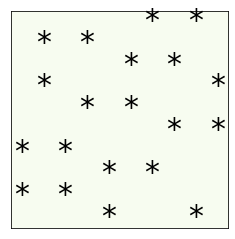

Satisfies constraints: True
Has lowest energy: True


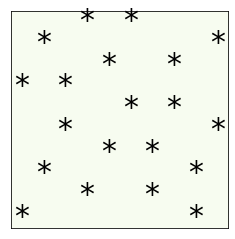

Satisfies constraints: True
Has lowest energy: True


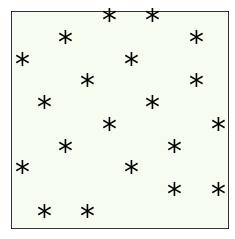

Satisfies constraints: True
Has lowest energy: True


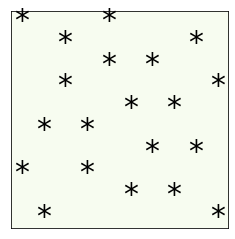

Satisfies constraints: True
Has lowest energy: True


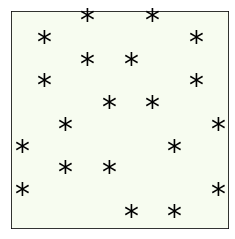

Satisfies constraints: True
Has lowest energy: True


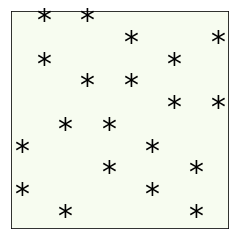

Satisfies constraints: True
Has lowest energy: True


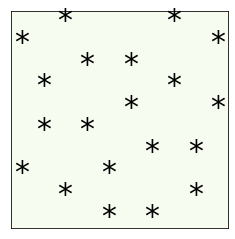

Satisfies constraints: True
Has lowest energy: True


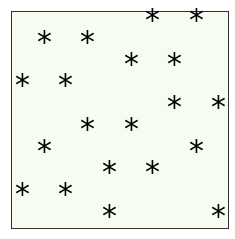

Satisfies constraints: True
Has lowest energy: True


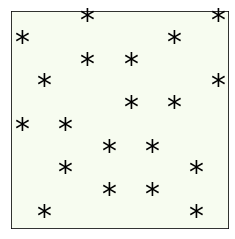

Satisfies constraints: True
Has lowest energy: True


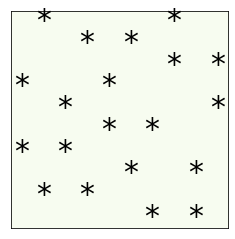

Satisfies constraints: True
Has lowest energy: True


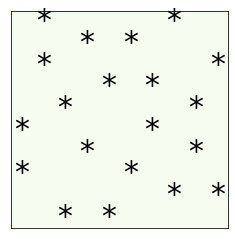

Satisfies constraints: True
Has lowest energy: True


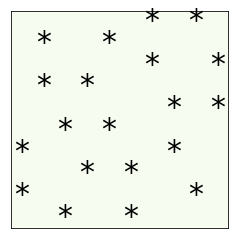

Satisfies constraints: True
Has lowest energy: True


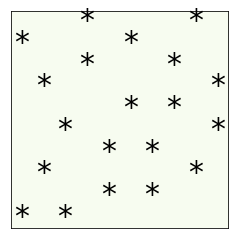

Satisfies constraints: True
Has lowest energy: True


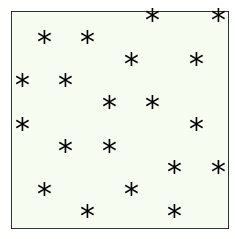

Satisfies constraints: True
Has lowest energy: True


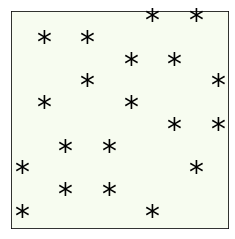

Satisfies constraints: True
Has lowest energy: True


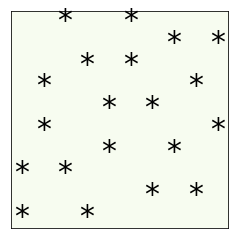

Satisfies constraints: True
Has lowest energy: True


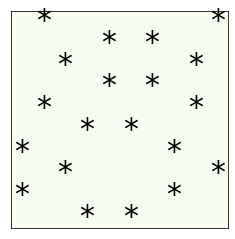

Satisfies constraints: True
Has lowest energy: True


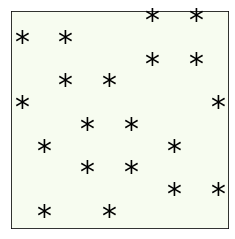

Satisfies constraints: True
Has lowest energy: True


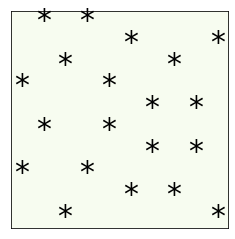

Satisfies constraints: True
Has lowest energy: True


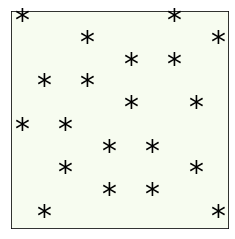

Satisfies constraints: True
Has lowest energy: True


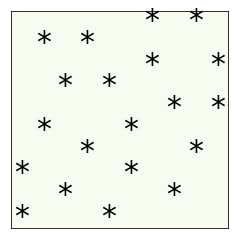

Satisfies constraints: False
Has lowest energy: False


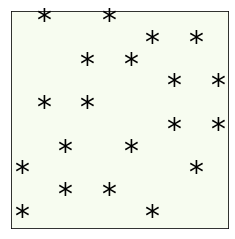

In [10]:
# sampleset = LEAPsampleset
sorted_records = sorted(sampleset.record, key=lambda r: r.energy)
variables = sampleset.variables
for record in sorted_records:
    sample = {x_ij: value for x_ij, value in zip(variables, record.sample)}
    energy = record.energy
    # if energy < -402:
    cond_1 = confirm_solution_stars(sample, regions, nstars)
    cond_2 = abs(energy-minimum_theo) < 1e-6
    print('Satisfies constraints:', cond_1)
    print('Has lowest energy:', cond_2)
    sample_to_plot(sample)
    if not cond_1 | cond_2:
        break

In [11]:
star_positions, solution, sample_star = get_star_positions(sampleset, 0)

Satisfies constraints: True
Has lowest energy: True


## Generate Regions

In [22]:
# Build Star Finder QUBO
g1, g2, g3, g4 = 1, 1, 1, 1
color_size = np.array([N]*N) #Number of sites per color
Q_reg_1 = g1 * constraint_sum_of_stars(N, nstars, star_positions)
Q_reg_2 = g2 * constraint_unique_color(N)
Q_reg_3 = g3 * constraint_contiguous(N)
Q_reg_4 = g4 * constraint_sum_of_sites(N,color_size)
Q_reg = Q_reg_1 + Q_reg_2 + Q_reg_3 + Q_reg_4

In [35]:
sampler2 = neal.SimulatedAnnealingSampler()
sampleset2 = sampler2.sample_qubo(Q_reg, num_reads=100)
#sampleset = LEAPsampleset
upper_bound = -g1*N*nstars**2 -g2*N**2 -g4*np.sum(color_size**2)
lower_bound = upper_bound - g3*4*N**2
print('Energy minimum between {} and {}.'.format(lower_bound, upper_bound))
print(sampleset2)

Energy minimum between -1540 and -1140.
   x0_0_0 x0_0_1 x0_0_2 x0_0_3 x0_0_4 x0_0_5 x0_0_6 ... x9_9_9  energy num_oc.
23      0      0      0      0      0      0      1 ...      1 -1270.0       1
30      0      0      0      0      0      0      0 ...      0 -1270.0       1
63      0      0      0      0      1      0      0 ...      0 -1270.0       1
74      0      0      0      0      0      1      0 ...      0 -1270.0       1
85      0      0      0      0      0      0      0 ...      0 -1270.0       1
3       0      0      0      0      0      1      0 ...      0 -1269.0       1
5       0      0      0      0      0      0      0 ...      0 -1269.0       1
39      0      0      0      0      0      0      1 ...      0 -1269.0       1
48      0      1      0      0      0      0      0 ...      0 -1269.0       1
59      0      0      0      0      0      0      0 ...      0 -1269.0       1
80      0      0      0      1      0      0      0 ...      0 -1269.0       1
83      0   

In [37]:
"""Do not delete!"""
# # sampleset = LEAPsampleset
# sorted_records2 = sorted(sampleset2.record, key=lambda r: r.energy)
# variables2 = sampleset2.variables
# conds = []
# for record2 in sorted_records2:
#     sample = {x_ij: value for x_ij, value in zip(variables2, record2.sample)}
#     energy = record.energy
#     grid = grid_solutions(sample)
#     regions = [
#         *region_lists(grid),
#         *row_regions(N),
#         *column_regions(N),
#     ]
#     # if energy < -402:
#     cond_1 = confirm_solution_stars(sample_star, regions, nstars)
#     conds += [int(cond_1)]
#     #cond_2 = abs(energy-minimum_theo) < 1e-6
#     print('Satisfies constraints:', cond_1)
#     #print('Has lowest energy:', cond_2)
#     sample_to_plot(solution, sample)
#     #if not cond_1:
#     #    break
# print(np.mean(conds))

'Do not delete!'

Energy: -1270.0 
Satisfies Constraints: True


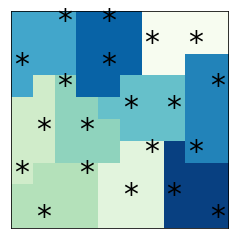

Energy: -1270.0 
Satisfies Constraints: True


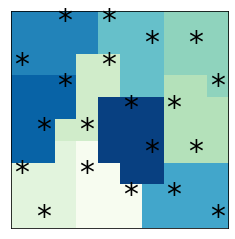

Energy: -1270.0 
Satisfies Constraints: True


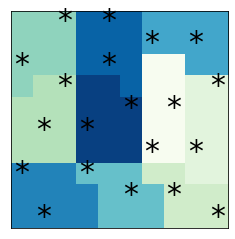

Energy: -1270.0 
Satisfies Constraints: True


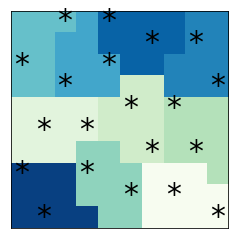

Energy: -1270.0 
Satisfies Constraints: True


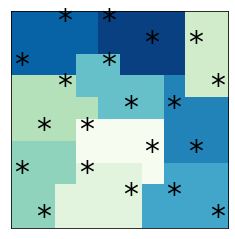

Energy: -1269.0 
Satisfies Constraints: True


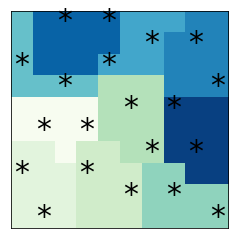

Energy: -1269.0 
Satisfies Constraints: True


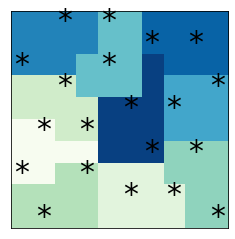

Energy: -1269.0 
Satisfies Constraints: True


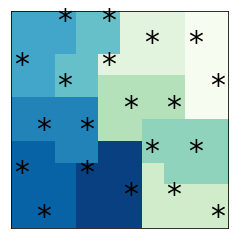

Energy: -1269.0 
Satisfies Constraints: True


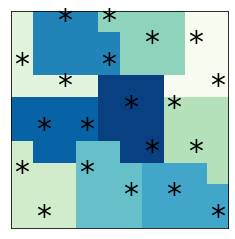

Energy: -1269.0 
Satisfies Constraints: True


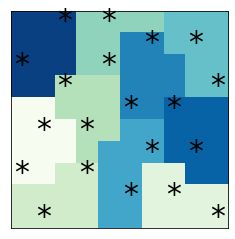

Energy: -1269.0 
Satisfies Constraints: True


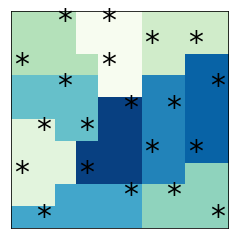

Energy: -1269.0 
Satisfies Constraints: True


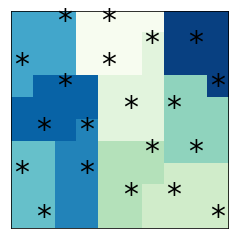

Energy: -1269.0 
Satisfies Constraints: True


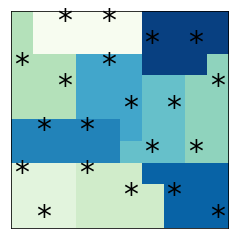

Energy: -1268.0 
Satisfies Constraints: False


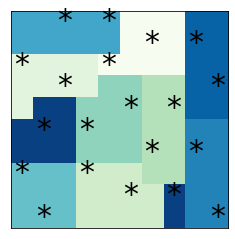

Energy: -1268.0 
Satisfies Constraints: False


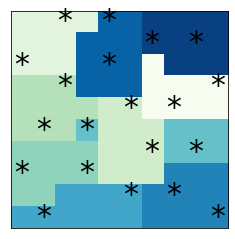

Energy: -1268.0 
Satisfies Constraints: False


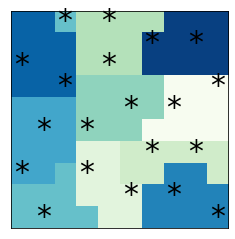

Energy: -1268.0 
Satisfies Constraints: False


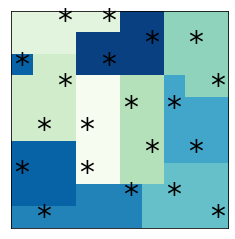

Energy: -1268.0 
Satisfies Constraints: False


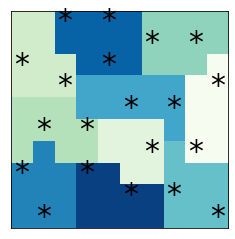

Energy: -1268.0 
Satisfies Constraints: False


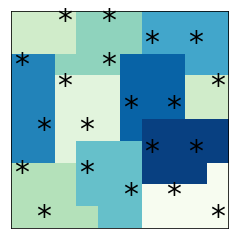

Energy: -1268.0 
Satisfies Constraints: True


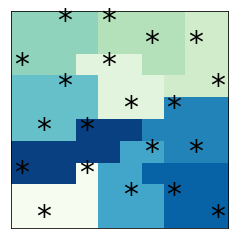

Energy: -1268.0 
Satisfies Constraints: False


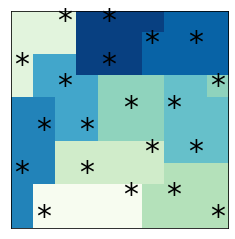

Energy: -1267.0 
Satisfies Constraints: False


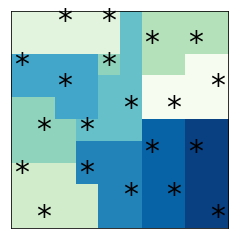

Energy: -1267.0 
Satisfies Constraints: False


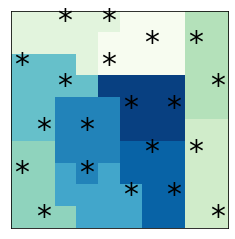

Energy: -1267.0 
Satisfies Constraints: False


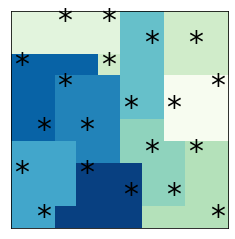

Energy: -1267.0 
Satisfies Constraints: False


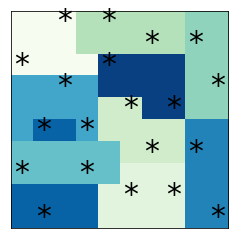

Energy: -1267.0 
Satisfies Constraints: False


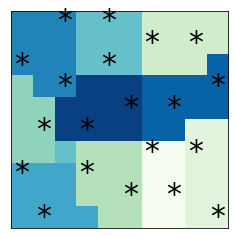

Energy: -1267.0 
Satisfies Constraints: False


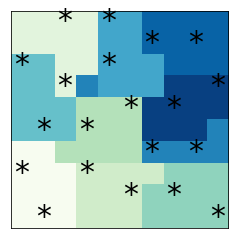

Energy: -1267.0 
Satisfies Constraints: False


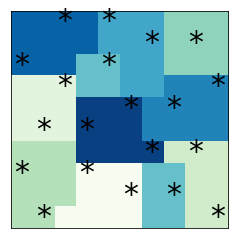

Energy: -1267.0 
Satisfies Constraints: False


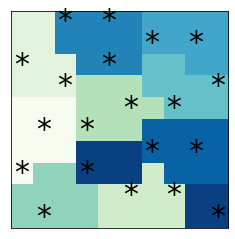

Energy: -1267.0 
Satisfies Constraints: False


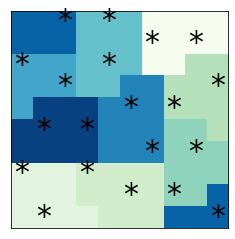

Energy: -1267.0 
Satisfies Constraints: False


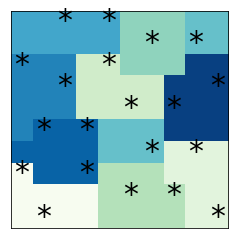

Energy: -1267.0 
Satisfies Constraints: False


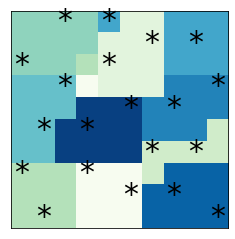

Energy: -1267.0 
Satisfies Constraints: False


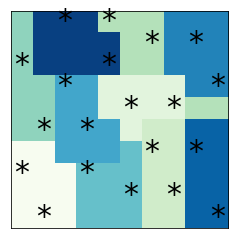

Energy: -1267.0 
Satisfies Constraints: False


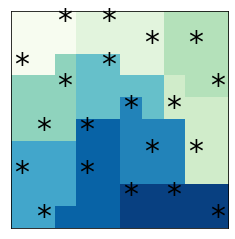

Energy: -1267.0 
Satisfies Constraints: False


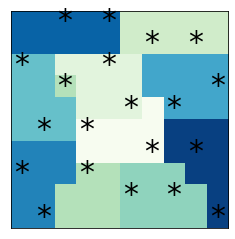

Energy: -1267.0 
Satisfies Constraints: False


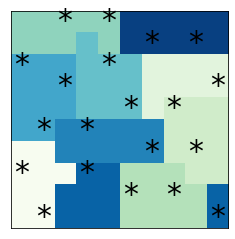

Energy: -1267.0 
Satisfies Constraints: False


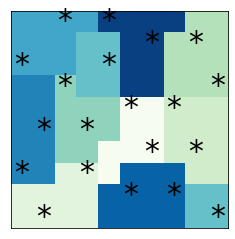

Energy: -1267.0 
Satisfies Constraints: False


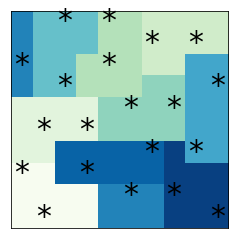

Energy: -1267.0 
Satisfies Constraints: False


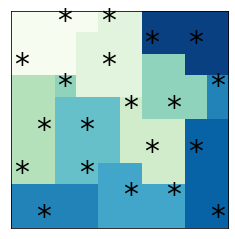

Energy: -1267.0 
Satisfies Constraints: False


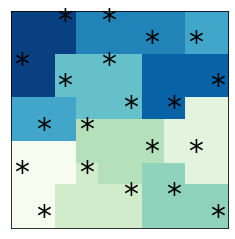

Energy: -1266.0 
Satisfies Constraints: False


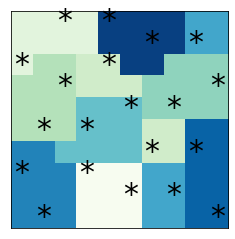

Energy: -1266.0 
Satisfies Constraints: False


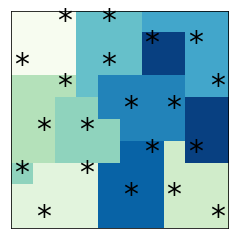

Energy: -1266.0 
Satisfies Constraints: False


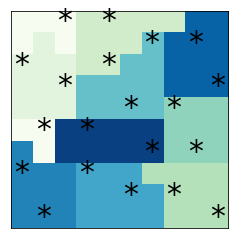

Energy: -1266.0 
Satisfies Constraints: False


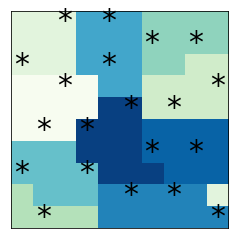

Energy: -1266.0 
Satisfies Constraints: False


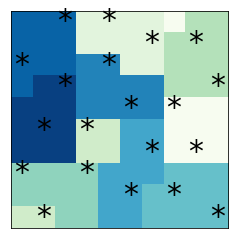

Energy: -1266.0 
Satisfies Constraints: False


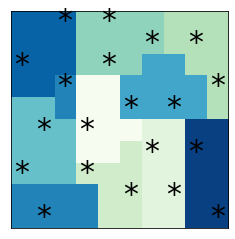

Energy: -1266.0 
Satisfies Constraints: False


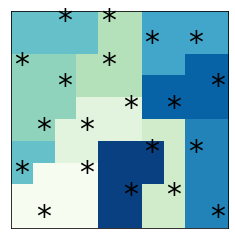

Energy: -1266.0 
Satisfies Constraints: False


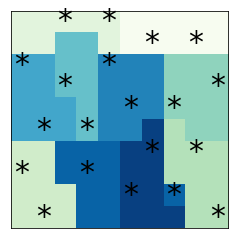

Energy: -1266.0 
Satisfies Constraints: False


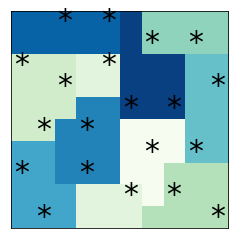

Energy: -1266.0 
Satisfies Constraints: False


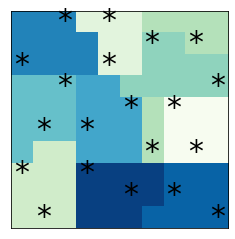

Energy: -1266.0 
Satisfies Constraints: False


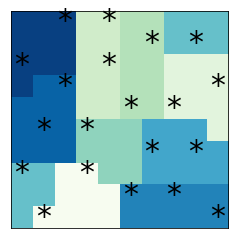

Energy: -1266.0 
Satisfies Constraints: False


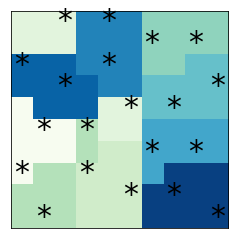

Energy: -1266.0 
Satisfies Constraints: False


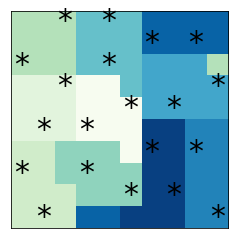

Energy: -1266.0 
Satisfies Constraints: False


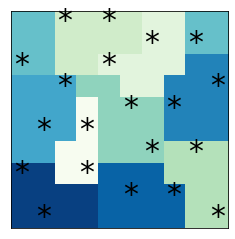

Energy: -1266.0 
Satisfies Constraints: False


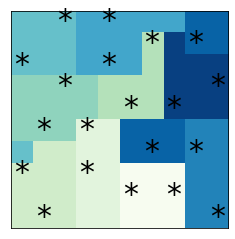

Energy: -1266.0 
Satisfies Constraints: False


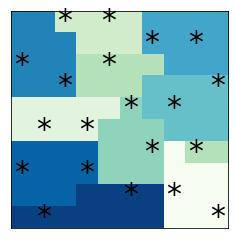

Energy: -1266.0 
Satisfies Constraints: False


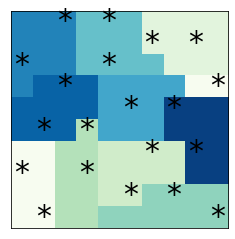

Energy: -1266.0 
Satisfies Constraints: False


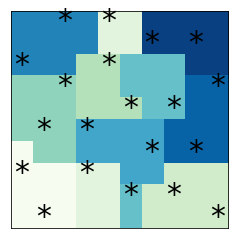

Energy: -1266.0 
Satisfies Constraints: False


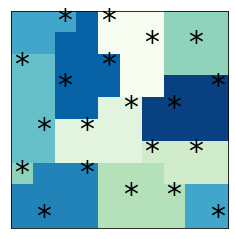

Energy: -1266.0 
Satisfies Constraints: False


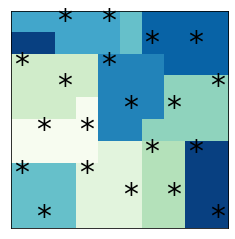

Energy: -1266.0 
Satisfies Constraints: False


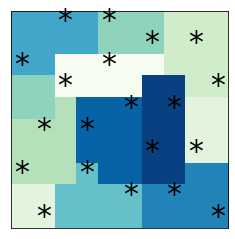

Energy: -1266.0 
Satisfies Constraints: False


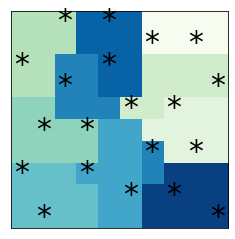

Energy: -1266.0 
Satisfies Constraints: False


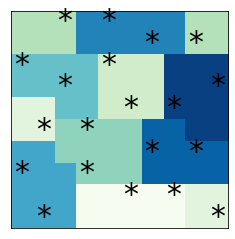

Energy: -1266.0 
Satisfies Constraints: False


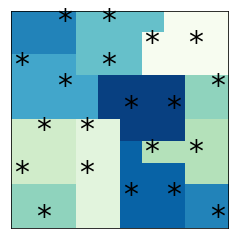

Energy: -1265.0 
Satisfies Constraints: False


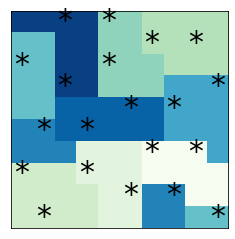

Energy: -1265.0 
Satisfies Constraints: False


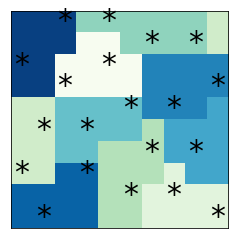

Energy: -1265.0 
Satisfies Constraints: False


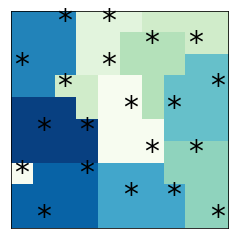

Energy: -1265.0 
Satisfies Constraints: False


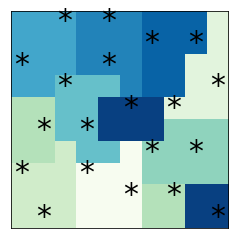

Energy: -1265.0 
Satisfies Constraints: False


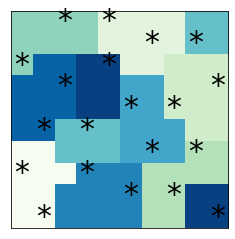

Energy: -1265.0 
Satisfies Constraints: False


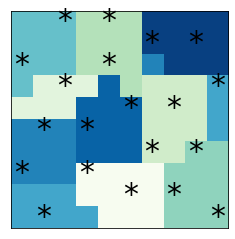

Energy: -1265.0 
Satisfies Constraints: False


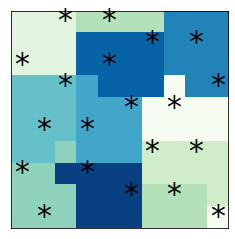

Energy: -1265.0 
Satisfies Constraints: False


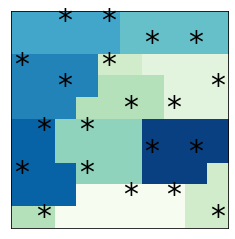

Energy: -1265.0 
Satisfies Constraints: False


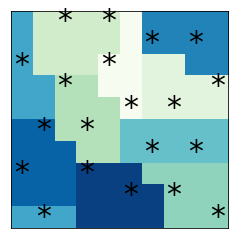

Energy: -1264.0 
Satisfies Constraints: False


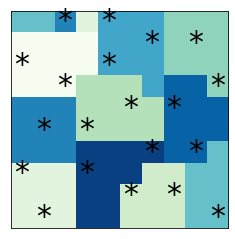

Energy: -1264.0 
Satisfies Constraints: False


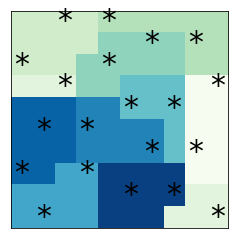

Energy: -1264.0 
Satisfies Constraints: False


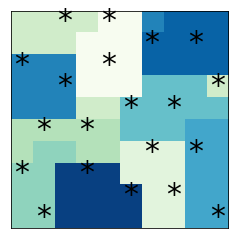

Energy: -1264.0 
Satisfies Constraints: False


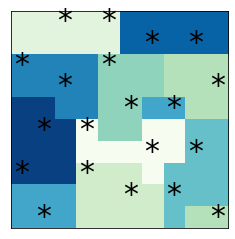

Energy: -1264.0 
Satisfies Constraints: False


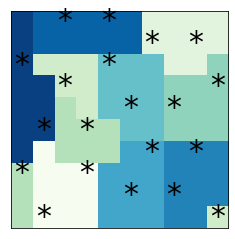

Energy: -1264.0 
Satisfies Constraints: False


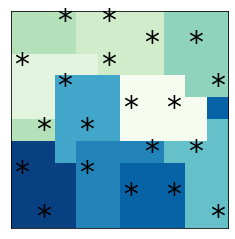

Energy: -1264.0 
Satisfies Constraints: False


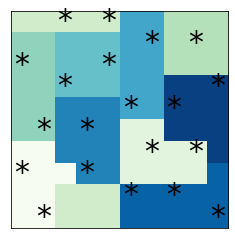

Energy: -1264.0 
Satisfies Constraints: False


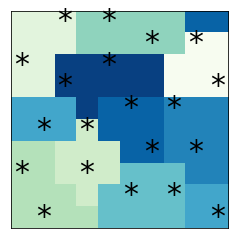

Energy: -1264.0 
Satisfies Constraints: False


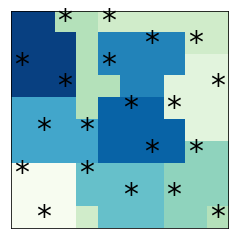

Energy: -1264.0 
Satisfies Constraints: False


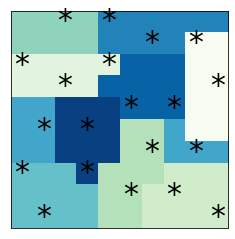

Energy: -1264.0 
Satisfies Constraints: False


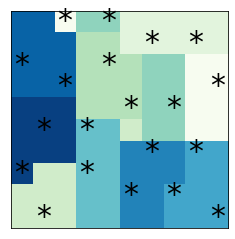

Energy: -1263.0 
Satisfies Constraints: False


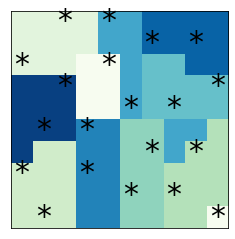

Energy: -1263.0 
Satisfies Constraints: False


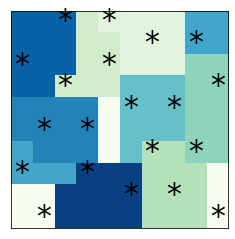

Energy: -1263.0 
Satisfies Constraints: False


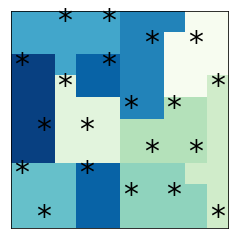

Energy: -1263.0 
Satisfies Constraints: False


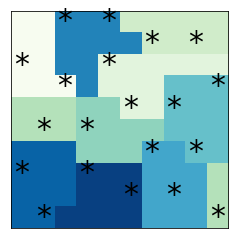

Energy: -1263.0 
Satisfies Constraints: False


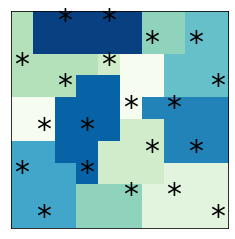

Energy: -1262.0 
Satisfies Constraints: False


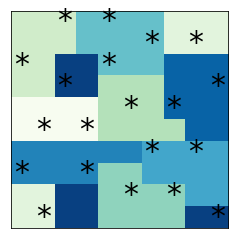

Energy: -1262.0 
Satisfies Constraints: False


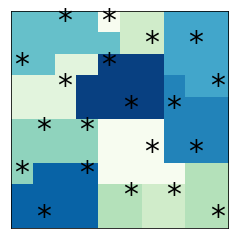

Energy: -1261.0 
Satisfies Constraints: False


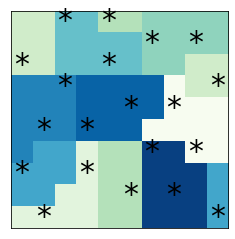

Energy: -1261.0 
Satisfies Constraints: False


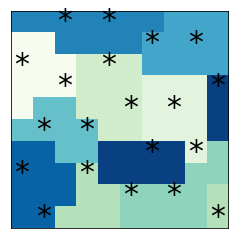

Energy: -1261.0 
Satisfies Constraints: False


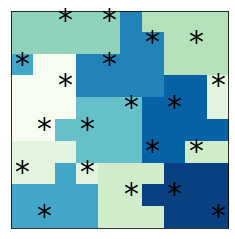

Energy: -1260.0 
Satisfies Constraints: False


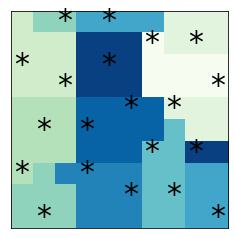

Energy: -1260.0 
Satisfies Constraints: False


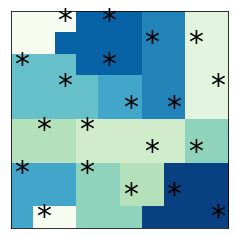

Energy: -1260.0 
Satisfies Constraints: False


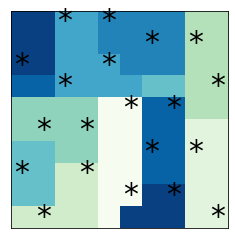

Energy: -1260.0 
Satisfies Constraints: False


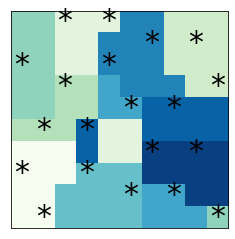

Energy: -1259.0 
Satisfies Constraints: False


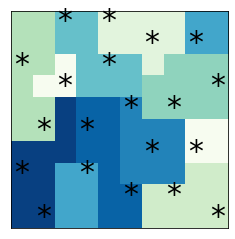

Energy: -1255.0 
Satisfies Constraints: False


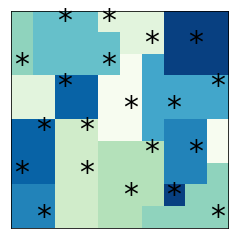

0.14


In [38]:
'''Confirm Solution of Regions'''

# sampleset = LEAPsampleset
sorted_records2 = sorted(sampleset2.record, key=lambda r: r.energy)
variables2 = sampleset2.variables
conds = []
for record2 in sorted_records2:
    sample = {x_ij: value for x_ij, value in zip(variables2, record2.sample)}
    energy = record2.energy
    grid = grid_solutions(sample)
    regions = [
        *region_lists(grid),
        *row_regions(N),
        *column_regions(N),
    ]
    if energy <= -lower_bound:
        cond1 = confirm_solution_regions(sample_star, grid, nstars)
        print('Energy: {} \nSatisfies Constraints: {}'.format(energy, cond1))
        sample_to_plot(solution, sample)
        conds += [int(cond1)]
print(np.mean(conds))

In [33]:
int(False)

0